In [1]:
import re
import numpy as np
import sys
import copy
import pandas as pd
import os
import math
import statistics
from os.path import join
import matplotlib.pyplot as plt 
from matplotlib import cm
import datetime
import itertools
import seaborn as sns

In [2]:
def file_convert(file_name):
    correct_name=file_name.replace(chr(92),'/')
    return correct_name

In [3]:
#import data
input_data = r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\0720_sporomusa_config.csv"
input_data = file_convert(input_data)
#import sample_sheet
input_sheet = r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\230720_sporomusa_eliminate_errors_samplesheet.xlsx"
input_sheet = file_convert(input_sheet)

In [4]:
# data selecting #indexはベースラインに合わせておく
data_start = 1
def import_data(input_data):
    #data selection
    global data_start
    data = pd.read_csv(input_data, header = None, index_col = None, sep = ",")
    
    if data.iloc[0,1]=='start':
        data_start=data_start+1
    selected = data.iloc[:,data_start:] 
    
    #inoculation_time
    time=data.iloc[:,0]
    time_over=pd.to_datetime(time, format='%Y/%m/%d %H:%M:%S').diff()
    time_over=time_over[::-1]
    inoculation_time = time_over[time_over > datetime.timedelta(minutes=2)].index[0]+1
    
    #230516_honjo
    #inoculation_time = time_over[time_over > datetime.timedelta(minutes=15)].index[0]+1

    #blank_time
    blank_time_min=str(time_over[inoculation_time-1]).split(':')[1]
    blank_time=pd.DataFrame(index=[t for t in range(int(blank_time_min))],columns=[x for x in range(0,int(selected.shape[1]/data_start))])
    baseline = data.iloc[inoculation_time-2,data_start::data_start]
    
    #菌体接種後のみ
    CA_data=data.iloc[inoculation_time:,data_start::data_start]
    baseline_data=data.iloc[:inoculation_time-2,data_start::data_start]
    
    #reset_columns index
    CA_data.columns = [x for x in range(CA_data.shape[1])]
    baseline=baseline.reset_index(drop=True)
    baseline_data.columns=[x for x in range(CA_data.shape[1])]
    blank_time.columns=[x for x in range(CA_data.shape[1])]
    
    #time calculation
    dt1=data[0][1]
    dt2=data[0][2]
    tdatetime1 = datetime.datetime.strptime(dt1, '%Y/%m/%d %H:%M:%S')
    tdatetime2 = datetime.datetime.strptime(dt2, '%Y/%m/%d %H:%M:%S')
    tdelta=tdatetime2-tdatetime1
    
    return tdelta,data_start,CA_data,baseline,inoculation_time,baseline_data,blank_time,selected

tdelta,data_start,CA_data,baseline,inoculation_time,baseline_data,blank_time,selected = import_data(input_data)

print(inoculation_time)
print(blank_time.shape[0])

135
23


In [ ]:
print(selected)

In [5]:
#yaru
sample_s1 = pd.read_excel(input_sheet,sheet_name = "Main", header = None, index_col = None)
sample_s1 = sample_s1.iloc[4:12,2:14]
sample_s1 = sample_s1.values
sample_s1 = np.ravel(sample_s1)
sample_s1 = sample_s1.astype(str)

In [6]:
#time conversion
def time(data):
    timescale="hour"
    #timescale="min"

    time = data.index.values
    if timescale == "hour":
        xdata = (time/3600)*tdelta.seconds
    elif timescale == "min":
        xdata = (time/60)*tdelta.seconds
    return xdata

xdata=time(selected)

In [7]:
#sort
sample_s_sort=np.sort(sample_s1,kind="mergesort")
sample_s_sort_id=np.argsort(sample_s1,kind="mergesort")
sample_CA_sort=selected.iloc[:,sample_s_sort_id*data_start]

CA_data=CA_data.iloc[:,sample_s_sort_id]
baseline=baseline[sample_s_sort_id]
baseline_data=baseline_data.iloc[:,sample_s_sort_id]
blank_time=blank_time.iloc[:,sample_s_sort_id]

CA_data.columns=[x for x in range(CA_data.shape[1])]
baseline=baseline.reset_index(drop=True)
baseline_data.columns=[x for x in range(baseline_data.shape[1])]
blank_time.columns=[x for x in range(blank_time.shape[1])]



In [ ]:
sample_s_sort

In [ ]:
CA_data

In [8]:
#データ選択
selected2=selected.iloc[:,::data_start]

In [9]:
#All wells in 96 position

#graph properties
fig = plt.figure(figsize=(24, 18),dpi = 500)
plt.subplots_adjust(wspace=0.7, hspace=0.7)

#drawing
for i in range (int(CA_data.shape[1])):
    plt.subplot(8,12,i+1)
    ydata = selected2.iloc[:,i]
    ydata = ydata*10**9
    plt.title('['+chr(i//12+65)+str(i%12+1)+']'+'\n'+str(sample_s1[i]), fontsize=12)
    plt.plot(xdata,ydata,linewidth=4,color='tab:red')
    plt.ylim(-600,0)
    plt.xlim(0,10)
#plt.savefig(r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\low_na2co3_allwells")
plt.show()

In [ ]:
#All wells in one figure

#graph properties
fig = plt.figure(figsize=(24, 18),dpi = 500)
plt.subplots_adjust(wspace=0.7, hspace=0.7)

#drawing
for i in range (int(selected2.shape[1])):
    ydata = selected2.iloc[:,i]
    ydata = ydata*10**9
    plt.xlabel('Time (hour)' ,fontsize = 20)
    plt.ylabel('Current (nA)',fontsize = 20)
    plt.plot(xdata,ydata,linewidth=0.5, label=
             '['+chr(i//12+65)+str(i%12+1)+']')
    legend = plt.legend(bbox_to_anchor=(0.5, 1.05), loc="lower center", borderaxespad=0, fontsize=15, ncol = int(CA_data.shape[1]/8))
plt.tick_params(labelsize=22)
plt.ylim(-100, 1500)
#plt.xlim(0, 6)
#plt.savefig(r"C:\Users\81906\Desktop\NIMS_experiments\0606_experiment\substrate_0606_result.xlsx")
plt.show()

In [10]:
#sample replication
sample_rep=[]
def sample_rep_comb(data):
    global sample_rep
    for i in range(len(data)):
        test=np.where(data==data[i])
        if i == 0:
            sample_rep.append(test)
        else:
            try:
                if(sample_rep[len(sample_rep)-1][0] == test[0]).all():
                    continue
                else:
                    sample_rep.append(test)
            except:
                sample_rep.append(test)
    return sample_rep

sample_rep = sample_rep_comb(sample_s_sort)

#the number of rep
rep_num=[]
for i in range(len(sample_rep)):
    rep_num.append(len(sample_rep[i][0]))
    
#compress_sample
comp_sample=[]
#t=0
for i in range(len(sample_rep)):
    comp_sample.append(sample_s_sort[sample_rep[i]][0])

C:\Users\81906\AppData\Local\Temp\ipykernel_17244\3024793473.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(sample_rep[len(sample_rep)-1][0] == test[0]).all():


In [11]:
#corration of error peak　＃ノイズ除去 #以下のベースライン除算、平均化とセットで行う
def remove_error_peak(run,data,time_span,current):
    if run == 1:
        #default
        #CA_data=sample_CA_sort 
        CA_diff=data.diff(time_span)
        CA_data_NaN=data.where(np.abs(CA_diff)<current, np.nan)
        CA_data_corr=CA_data_NaN.astype(float).interpolate()
        #window=60
        #CA_data_corr=CA_data_corr.rolling(window, center=True).mean()
    elif run == 0:
        CA_data_corr=data
    return CA_data_corr

#(t)秒前よりも(current)A変動
peak_remove =1 #No=0, run=1

CA_error_peak_removed=remove_error_peak(peak_remove,CA_data,1,1*10**-9)
CA_error_peak_removed_baseline=remove_error_peak(peak_remove,baseline_data,1,1*10**-9)
CA_error_peak_removed_blank_time=remove_error_peak(peak_remove,blank_time,1,1*10**-9)

In [ ]:
CA_data

In [ ]:
#baseline substraction 　＃やらない　最小値をベースラインとして全体から引く
#全体のminを引く
def baseline_substraction(run):
    CA_data_bs = pd.DataFrame(index=[])
    if run == 1:
        CA_first=CA_error_peak_removed
        CA_first=CA_first.min()
        CA_first=CA_first.reset_index()
        for i in range (CA_error_peak_removed.shape[1]):
            CA_data_bs.loc[:,i]=CA_error_peak_removed.iloc[:,i]-CA_first.loc[i].iloc[-1]
    elif run == 0:
        CA_data_bs=CA_error_peak_removed
    return CA_data_bs


Base_sub = 1 #0 = No,1=run
CA_data_bs=baseline_substraction(Base_sub)

In [12]:
#baseline substraction
#inoculationの前を引く
def baseline_substraction(run,data):
    if run == 1:
        CA_data_bs=data-baseline
    elif run == 0:
        CA_data_bs=data
    return CA_data_bs

Base_sub = 1 #0 = No,1=run
CA_data_bs=baseline_substraction(Base_sub,CA_error_peak_removed)
CA_data_bs_baselline=baseline_substraction(Base_sub,CA_error_peak_removed_baseline)
CA_data_bs_blank_time=baseline_substraction(Base_sub,CA_error_peak_removed_blank_time)

In [ ]:
#Average with Standard Deviation　＃やらない

replicate = 8
n_comb = 5

import collections

def average(data):
    ave = pd.DataFrame(columns=[int(x) for x in np.linspace(0,int((data.shape[1])/replicate)-1,int((data.shape[1])/replicate))])
    SD_check=[]
    SD_comb=[]
    for s in range(ave.shape[1]):
        f_col = s*replicate
        e_col = f_col+replicate
        sample_judge=data.iloc[:,f_col:e_col]

        #組み合わせを取得
        combination_array=[]
        for index in itertools.combinations(sample_judge.columns, n_comb):
            combination_array.append(index)
        comb=np.array(combination_array)
        SD_comb.append(comb)

        SD_min_all=[]
        for t in range (0,int(sample_judge.shape[0]/60),1):
            SD_array=[]
            for current in comb:
                SD_array.append(np.std(sample_judge.iloc[t*60,current%replicate]))
                SD_min=SD_array.index(min(SD_array))
            SD_min_all.append(SD_min)
        SD_check.append(SD_min_all)
        #mode = statistics.mode(SD_min_all)
        mode = collections.Counter(SD_min_all).most_common()[0][0]
        sample_i=data.loc[:,comb[mode]]
        print(sample_i)
        ave.loc[:,s] = np.mean(sample_i,axis=1)
        
    return ave
    
CA_data_final=average(CA_data_bs)
#average_for10=average(CA_data_rep10)

#smoothing range
window=1*60

#average_for10=average_for10.rolling(window, center=True).mean()

CA_data_final=CA_data_final.rolling(window, center=True).mean()

In [ ]:
sample_rep

In [13]:
#Average　
def average2(data):
    CA_average = pd.DataFrame(columns=[int(x) for x in np.linspace(0,len(comp_sample)-1,len(comp_sample))])
    for s in range(len(sample_rep)):
        CA_average.loc[:,s] = np.mean(data.iloc[:,sample_rep[s][0]],axis=1)
    return CA_average

CA_data_final=average2(CA_data_bs)
CA_baseline_ave=average2(CA_data_bs_baselline)
blank_time_ave=average2(CA_data_bs_blank_time)

#smoothing range
window=1*60
CA_data_final=CA_data_final.rolling(window, center=True).mean()

C:\Users\81906\AppData\Local\Temp\ipykernel_17244\3800881019.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  CA_average.loc[:,s] = np.mean(data.iloc[:,sample_rep[s][0]],axis=1)
C:\Users\81906\AppData\Local\Temp\ipykernel_17244\3800881019.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  CA_average.loc[:,s] = np.mean(data.iloc[:,sample_rep[s][0]],axis=1)
C:\Users\81906\AppData\Local\Temp\ipykernel_17244\3800881019.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of 

In [ ]:
def get_number(item):
    return int(item.split('-')[-1].replace('µM', ''))

comp_sample = sorted(comp_sample, key=get_number, reverse=True)
comp_sample

In [ ]:
Time

<function matplotlib.pyplot.show(close=None, block=None)>

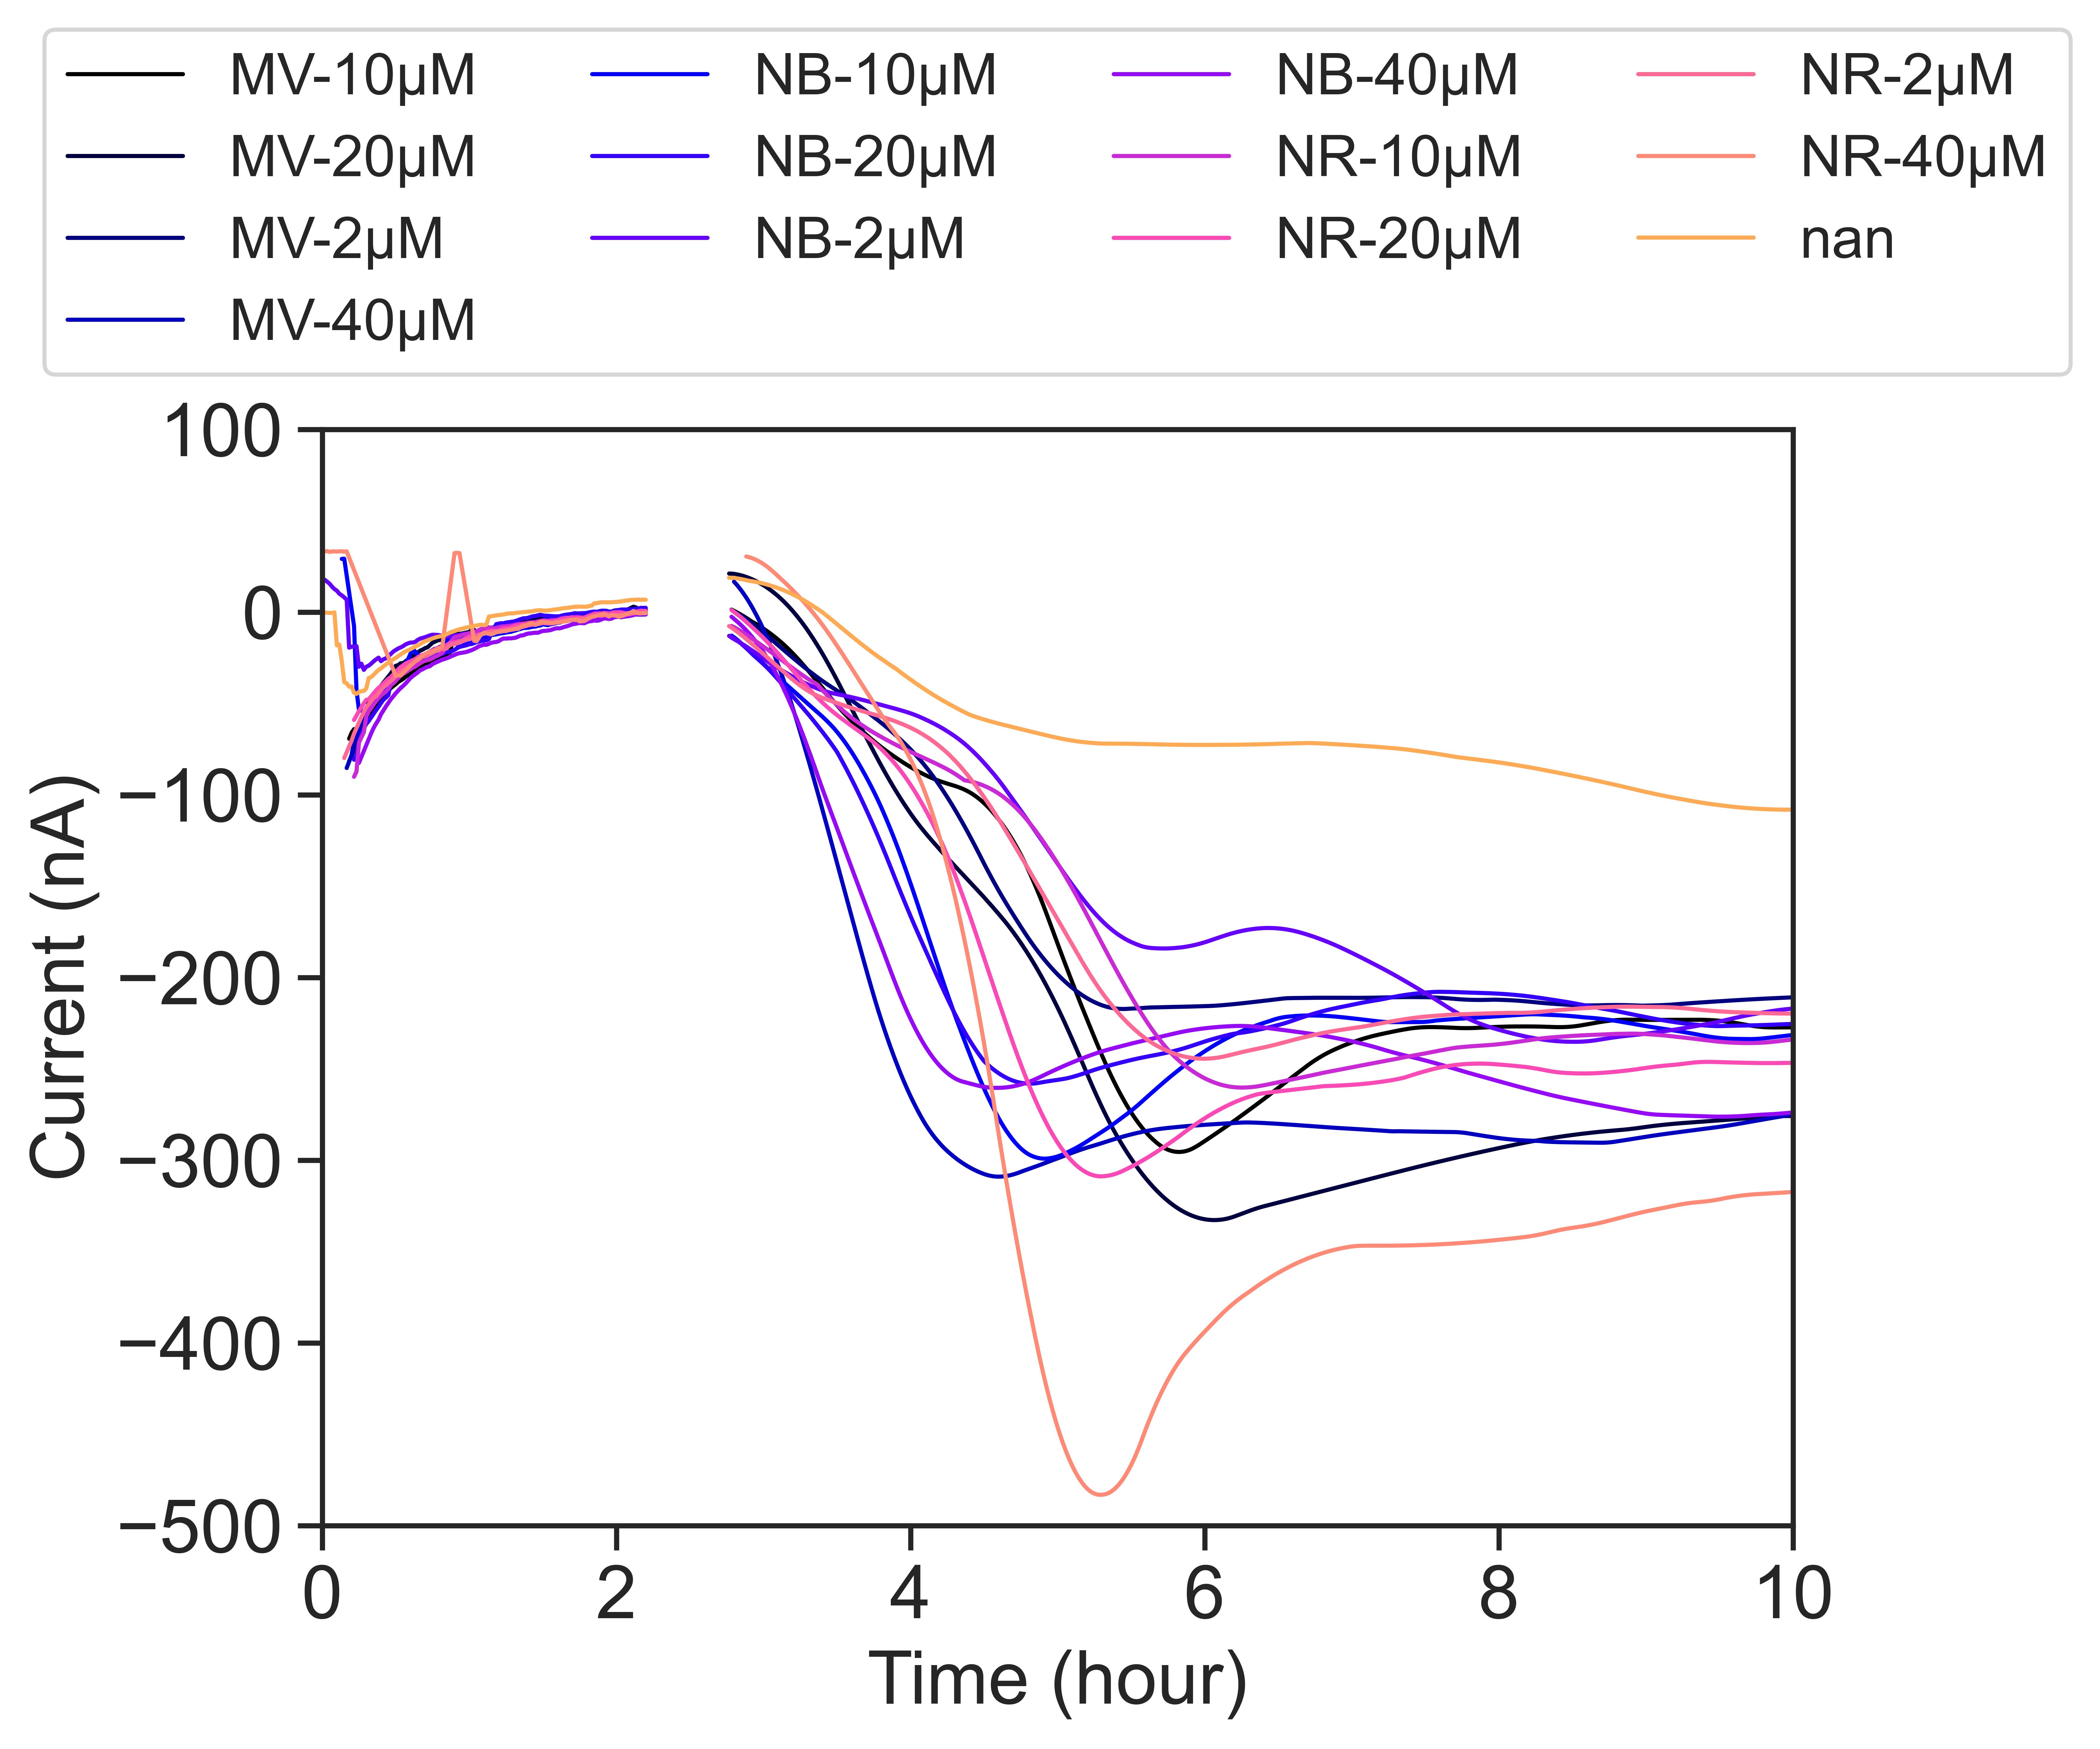

In [14]:
# All CA data (Average)

#graph proerties
fig = plt.figure(dpi=1000)
plt.rcParams['font.family'] = 'Arial'
sns.set()
sns.set_style('ticks')
#sns.set_palette('hls',CA_data_final.shape[1])
ax = fig.add_subplot(111)
plt.xlabel('Time (hour)' ,fontsize = 18)
plt.ylabel('Current (nA)',fontsize = 18)

#baseline含む #
#CA_data_all_ave=pd.concat([CA_error_peak_removed_baseline,CA_error_peak_removed_blank_time,CA_error_peak_removed])
#CA_data_all_ave=pd.concat([CA_data_bs_baselline,CA_data_bs_blank_time,CA_data_bs])
CA_data_all_ave=pd.concat([CA_baseline_ave,blank_time_ave,CA_data_final])
#CA_data_all_ave=CA_data_final

#repricateの番号
#a=2 #a:1~6 repricatesをあらわす
#a=a-1
#CA_data_all_ave= CA_data_all_ave.iloc[:,a::6]

#sample_list=[1,2,16,17,22,23]
#color
#cm = ['red', 'lightcoral', 'navy', 'lightblue','black', 'gray']
#name = ['WT+BB24', 'ΔtolC+BB24', 'WT+NB', 'ΔtolC+NB', 'WT', 'ΔtolC']
cm = plt.get_cmap("gnuplot2")
#drawing
t=0
x=0
for i in range(int(CA_data_all_ave.shape[1])):
    if i< 24:
    #if i in range(16,32):
        ydata = CA_data_all_ave.iloc[:,i]
        ydata = ydata*10**9
        plt.plot(time(CA_data_all_ave),ydata,linewidth=1,label = comp_sample[i], color = cm(i/16))
        #plt.plot(time(CA_data_all_ave),ydata,linewidth=1, label=name[x], color = cm[x])
       #x=x+1
    #t=t+rep_num[i]
    legend = plt.legend(bbox_to_anchor=(0.5, 1.05), loc="lower center", borderaxespad=0, fontsize=14, ncol = 4)
plt.ylim(-500, 100)
plt.xlim(0, 10)
#plt.yticks(np.arange(0,1401,200))
#plt.xticks(np.arange(0,11))
plt.tick_params(labelsize=18)
#plt.savefig(r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\mediator_concentration_data/MV",facecolor="white",bbox_inches='tight')
plt.show

In [15]:
#Time=time(CA_data_all_ave)
CA_data_all_ave.reset_index(inplace=True,drop=True)
CA_data_all_ave.columns=comp_sample
Time=pd.DataFrame(time(CA_data_all_ave))
CA_data_all_ave_output=pd.concat([Time,CA_data_all_ave],axis=1)
file_name=r'C:\Users\81906\Desktop\conda data_analysis NIMS\4_mediators_Current5'
file_name=file_name+'.xlsx'
CA_data_all_ave_output.to_excel(file_name)

In [ ]:
CA_data_all_ave.reset_index(inplace=True)

In [ ]:
CA_data_all_ave

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate


In [ ]:
 # 積分結果を格納するリスト
integrated_data = r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\230720_sporomusa_integrateddata.xlsx"
input_sheet = file_convert(integrated_data)
integral_values = [integrated_data] 
t=0
x=0
for i in range(int(CA_data_all_ave.shape[1])):
    if i< 12:
    #if i in range(16,32):
        ydata = CA_data_all_ave.iloc[:,i]
        ydata = ydata*10**9
        plt.plot(time(CA_data_all_ave),ydata,linewidth=1,label = comp_sample[i], color = cm(i/16))
        #plt.plot(time(CA_data_all_ave),ydata,linewidth=1, label=name[x], color = cm[x])
       #x=x+1
        integral = integrate.simps(ydata, time(CA_data_all_ave))  # シンプソン則を用いて積分
        integral_values.append(integral)
    #t=t+rep_num[i]
    legend = plt.legend(bbox_to_anchor=(0.5, 1.05), loc="lower center", borderaxespad=0, fontsize=14, ncol = 4)
plt.ylim(-500, 100)
plt.xlim(0, 10)
#plt.yticks(np.arange(0,1401,200))
#plt.xticks(np.arange(0,11))
plt.tick_params(labelsize=18)
#plt.savefig(r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\mediator_concentration_data/MV",facecolor="white",bbox_inches='tight')
plt.show

In [ ]:
# 結果を表示
for i, column in range(CA_data_all_ave.shape[1]):
    print(f"Sample {column}: Integral = {integral_values[i]}")

# 積分結果をプロット
plt.bar(current_columns.columns, integral_values)
plt.xlabel('サンプル')
plt.ylabel('積分値')
plt.title('電流値の時間積分')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
time(CA_data_all_ave)

In [ ]:

def plot_current_over_time(csv_file):
    # CSVファイルを読み込む
    df = pd.read_csv(r"C:\Users\81906\Desktop\研究関連\NIMS_experiments\0714_sporomusa\0720_sporomusa_config.csv")
    if data.iloc[0,1]=='start':
        data_start=data_start+1
    selected = data.iloc[:,data_start:]
    
    # 時間と電流値の列を取得
    time_column = df['時間（分）']
    current_columns = df.drop(columns=['時間（分）'])  # 時間列を削除
    
    # プロット
    plt.figure(figsize=(10, 6))  # プロットのサイズを指定
    
    for column in current_columns.columns:
        plt.plot(time_column, current_columns[column], label=column)
    
    plt.xlabel('時間（分）')
    plt.ylabel('電流値')
    plt.title('電流値の経時的変化')
    plt.legend()  # 凡例を表示
    plt.grid(True)  # グリッドを表示
    
    plt.show()

# CSVファイル名を指定してプロット関数を呼び出す
plot_current_over_time('ファイル名.csv')

In [ ]:
#current
CA_data_final_current=CA_data_final.iloc[:60*70,:].max()
CA_data_final_current_time=CA_data_final.iloc[:60*70,:].idxmax()

In [ ]:
CA_data

In [ ]:
CA_data_bs.loc[425,0::6]*10**9

In [ ]:
CA_data_final_current_time/60

In [ ]:
CA_data_final_current.index=[comp_sample]
CA_data_final_current_time.index=[comp_sample]

In [ ]:
CA_data_final_current_time=CA_data_final_current_time/60

In [ ]:
CA_data_final_current.to_csv('/Users/takashi/Documents/岡本研/実験関係/メディエーター/実験データ/大腸菌/thio_mutant/230520/max_current')
CA_data_final_current_time.to_csv('/Users/takashi/Documents/岡本研/実験関係/メディエーター/実験データ/大腸菌/thio_mutant/230520/max_current_time')





In [ ]:
list=[0, 3, 3, 3, 0, 3, 2, 3, 2, 0, 3, 3, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0,2, 3]

list2=[]
for i in range(len(list)):
    a=np.array(list[i])+4*i
    list2.append(a)

In [ ]:
list2

In [ ]:
comp_sample

In [ ]:
CA_data_final_current

In [ ]:
CA_data_final_current_time/60

In [ ]:
main=[x for x in range(0,36) if x%3 != 0]

In [ ]:
comp_sample

In [ ]:
CA_data_final_current[main]

In [ ]:
#slope
CA_data_final_slope=CA_data_final.diff()
#slope_max=CA_data_final_slope.iloc[1*60*60:,:].max()
slope_max=CA_data_final_slope.max()
#slope_max_time=CA_data_final_slope.iloc[1*60*60:,:].idxmax()
slope_max_time=CA_data_final_slope.idxmax()

In [ ]:
slope_max_time/60

In [ ]:
slope_max

In [ ]:
slope_max[main]

In [ ]:
##for mPMS##
#2時間以降
CA_data_final_current=CA_data_final.iloc[2*60:,:].max()
CA_data_final_current_time=CA_data_final.iloc[2*60:,:].idxmax()


CA_data_final_slope=CA_data_final.diff(1*60)
slope_max=CA_data_final_slope.iloc[2*60:,:].max()
slope_max_time=CA_data_final_slope.iloc[2*60:,:].idxmax()

In [ ]:
slope_max

In [ ]:
#All CA data (Average) with max slope and current

#graph proerties
fig = plt.figure(dpi=500)
plt.rcParams['font.family'] = 'Arial'
sns.set()
sns.set_style('ticks')
sns.set_palette('hls',CA_data_final.shape[1])
ax = fig.add_subplot(111)
plt.xlabel('Time (hour)' ,fontsize = 18)
plt.ylabel('Current (nA)',fontsize = 18)

#CA_data_all_ave=CA_data_final

#drawing
t=0
#for i in range(int(CA_data_all_ave.shape[1])):
#for i in range(16,25):
for i in [16,17,18,19,27,28,29,30,31]:
    ydata =CA_data_all_ave.iloc[:,i]
    ydata = ydata*10**9
    plt.plot(time(CA_data_all_ave),ydata,linewidth=1, label=comp_sample[i])
    plt.plot(CA_data_final_current_time[i]/60,CA_data_final[i][CA_data_final_current_time[i]]*10**9,"bo")
    #plt.plot(slope_max_time[i]/60,CA_data_final[i][slope_max_time[i]]*10**9,"ro")
    t=t+rep_num[i]
    legend = plt.legend(bbox_to_anchor=(0.5, 1.05), loc="lower center", borderaxespad=0, fontsize=14, ncol = 3)
plt.ylim(0, 2200)
plt.xlim(0, 34)
#plt.yticks(np.arange(0,1401,200))
plt.xticks(np.arange(0,35,2))
plt.tick_params(labelsize=18)
#plt.savefig('/Users/takashi/Documents/岡本研/実験関係/代謝(基質)/sub1_withmax_use',facecolor="white",bbox_inches='tight')
plt.show

In [ ]:
##All wells in one sample with average##

#def allwell_average(data_name, file_name):
#graph proerties

CA_data_bs_all=pd.concat([CA_data_bs_baselline,CA_data_bs_blank_time,CA_data_bs])

#base_data=CA_data_rep10
#average_data=average_for10


average_data=CA_data_all_ave
base_data=CA_data_bs_all

replicate=3

fig = plt.figure(figsize=(60, 200))
plt.rcParams['font.family'] = 'Arial'
sns.set()
sns.set_style('ticks')
sns.set_palette('hls',CA_data_final.shape[1])
ax = fig.add_subplot(111)

#drawing
s=0
for i in range (len(rep_num)):
#for i in range (8):
    #for t in range(i*replicate,(i+1)*replicate):
    #for t in range(s,s+rep_num[i]):
    for t in range(s,s+replicate):
        plt.subplot(int(base_data.shape[1]/3),3,i+1)
        plt.xlabel('Time (hour)' ,fontsize = 25)
        plt.xticks(fontsize=20)
        plt.ylabel('Current (nA)',fontsize = 25)
        plt.yticks(fontsize=20)
        ydata = base_data.iloc[:,t]
        ydata = ydata*10**9
        plt.plot(time(ydata),ydata,linewidth=1,color='gray')
    #drawing with average
    ydata_a = average_data.iloc[:,i]
    ydata_a = ydata_a*10**9
    plt.plot(time(ydata_a),ydata_a,linewidth=1, color='red')
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.title(comp_sample[i],fontsize=30)
    #s=s+rep_num[i]
    s=s+replicate
    #plt.ylim(-50, 300)
    #plt.xlim(1, 20)
#plt.ioff()
#plt.savefig(dirname+bac_name+date+'replicate+average'+file_name,bbox_inches='tight')
plt.savefig('/Users/takashi/Documents/岡本研/実験関係/メディエーター/実験データ/大腸菌/thio_mutant/230520/average_with_rep',facecolor="white",bbox_inches='tight')
#plt.close(fig)
plt.show()

#allwell_average(CA_data, 'rawdata')
#allwell_average(CA_data_bs, 'correction')